<H1>Stratégie Envelope</H1>
Indicateurs: Envelope + SMA<br>
SEG

In [41]:
# Modules standards
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ta
# Modules perso
from utilities.strategies import Envelope
from utilities.data_manager import ExchangeDataManager
from utilities.bt_analysis import simple_backtest_analysis, get_metrics
from utilities.plot_analysis import plot_equity_vs_asset, plot_bar_by_month

In [42]:
exchange_name = "bitget"
pair = "TRX/USDT:USDT"
coin = pair.split('/')[0]
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

<H2>Backtest</H2>

╒═════════════════════════════╤════════════════════════════════════════════════════════╕
│ Résultats backtest          │ TRX/USDT:USDT(1h)                                      │
╞═════════════════════════════╪════════════════════════════════════════════════════════╡
│ Période                     │ 31.08.2020 -> 02.02.2024                               │
│ Portefeuille initial        │ 1,000.00 $                                             │
│                             │                                                        │
│ Portefeuille final          │ 5,655.49 $                                             │
│ Performance vs US dollar    │ 465.55 %                                               │
│ Pire Drawdown T|D           │ -16.53% | -16.16%                                      │
│ Buy and hold performance    │ 325.26 %                                               │
│ Performance vs buy and hold │ 32.99 %                                                │
│ Nombre total de tra

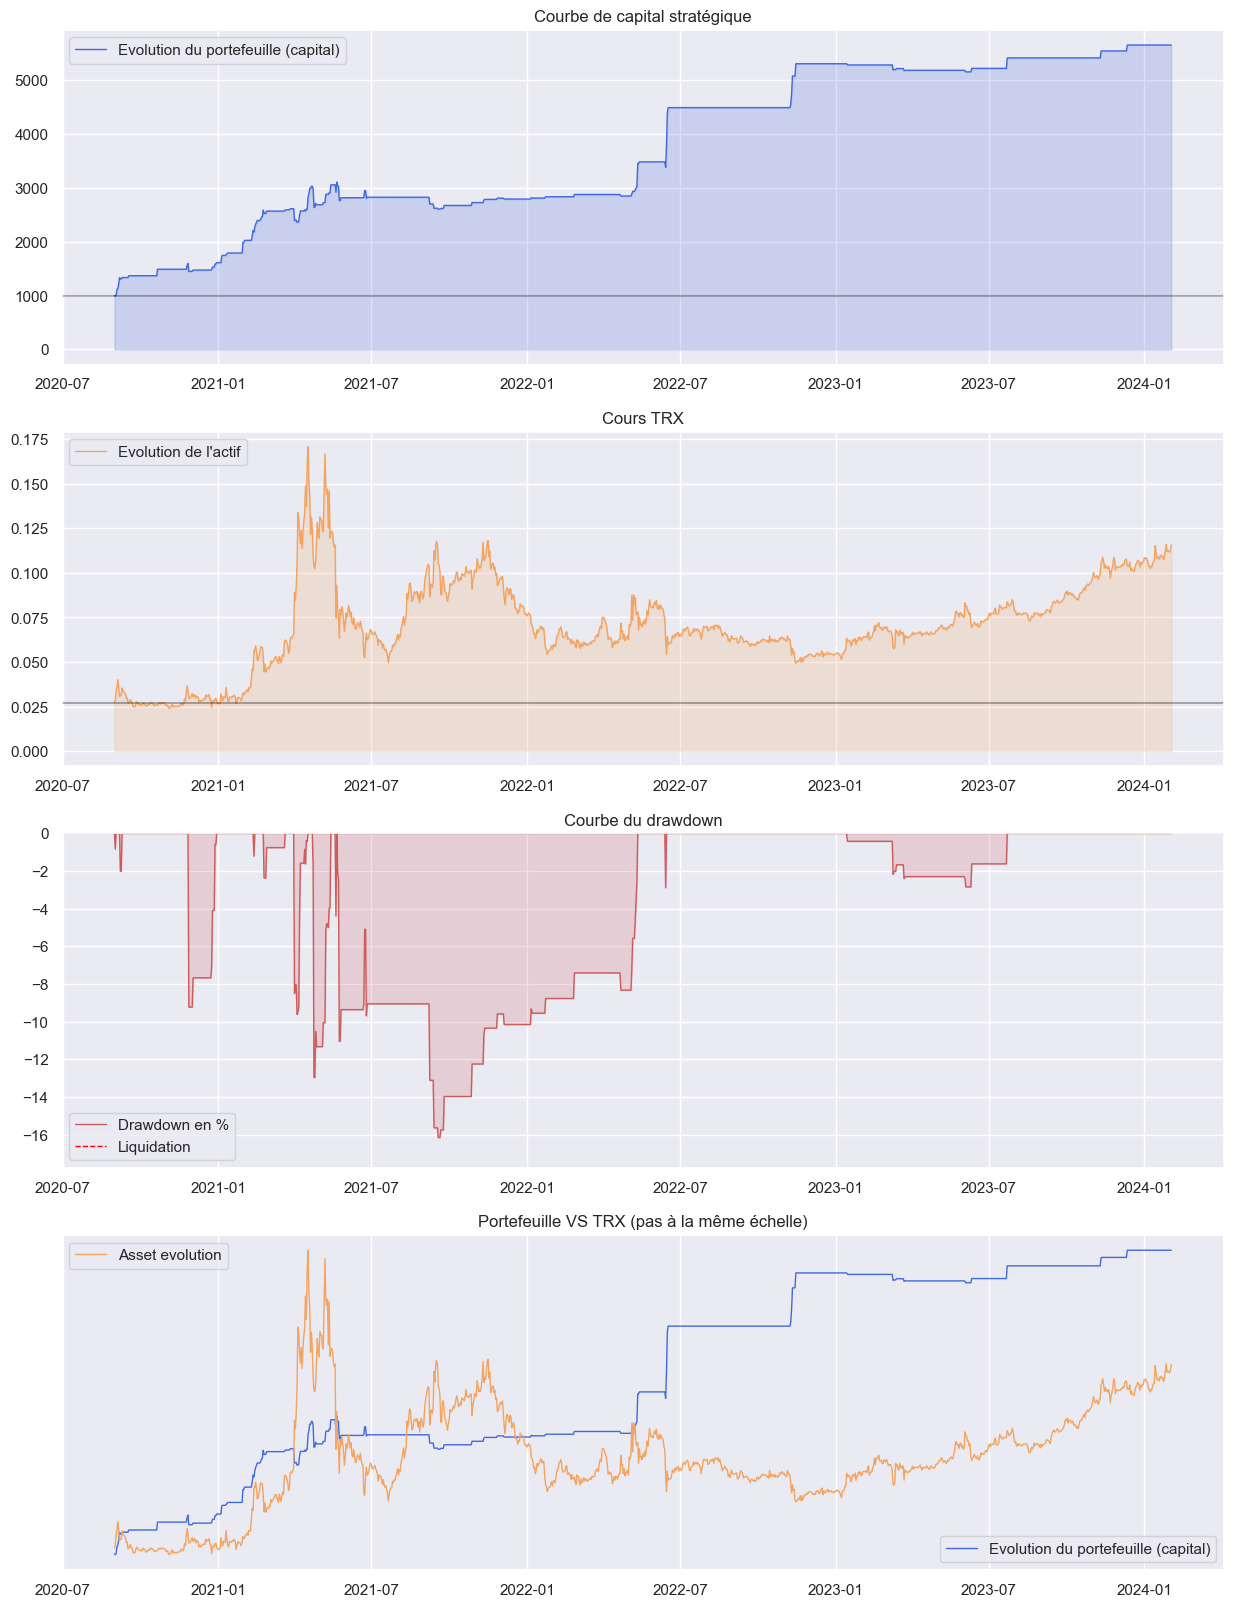

In [54]:
# strat = Envelope( # BTC
#     df = df.loc["2018":], type=["long", "short"], ma_base_window=8, envelopes=[0.07, 0.08, 0.1], src="close",)
strat = Envelope( # ETH
     df = df.loc["2019":], type=["long", "short"], ma_base_window=8, envelopes=[0.08, 0.1, 0.12], src="close",)
# strat = Envelope( # ADA EGLD
#     df = df.loc["2018":], type=["long", "short"], ma_base_window=6, envelopes=[0.05, 0.08, 0.1, 0.12], src="close",)
# strat = Envelope( # KSM OCEAN REN BAR
#     df = df.loc["2018":], type=["long", "short"], ma_base_window=5, envelopes=[0.06, 0.12, 0.15, 0.2], src="close",)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, reinvest=True)

df_trades, df_days = simple_backtest_analysis(trades=bt_result['trades'], days=bt_result['days'], pair=pair, tf=tf)
plot_equity_vs_asset(df_days=df_days, pair=pair)

<H3>Performance par mois et année</H3>

----- 2020 Cumulative Performances: 38.57% -----


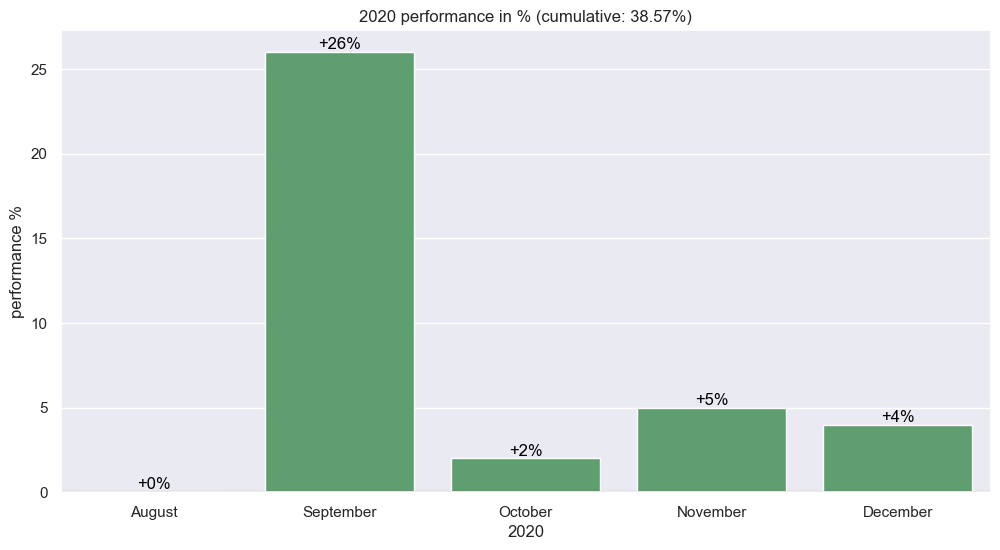

----- 2021 Cumulative Performances: 36.24% -----


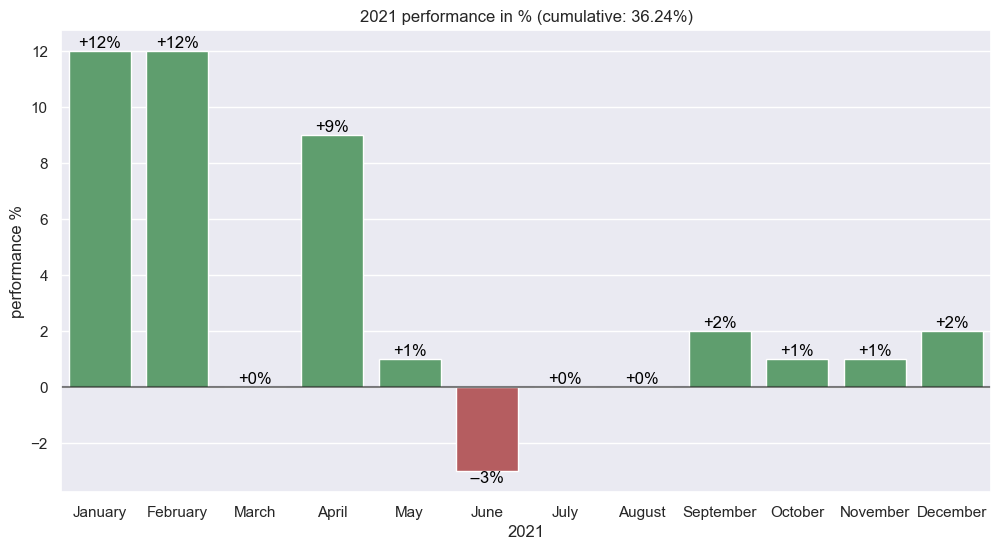

----- 2022 Cumulative Performances: 25.73% -----


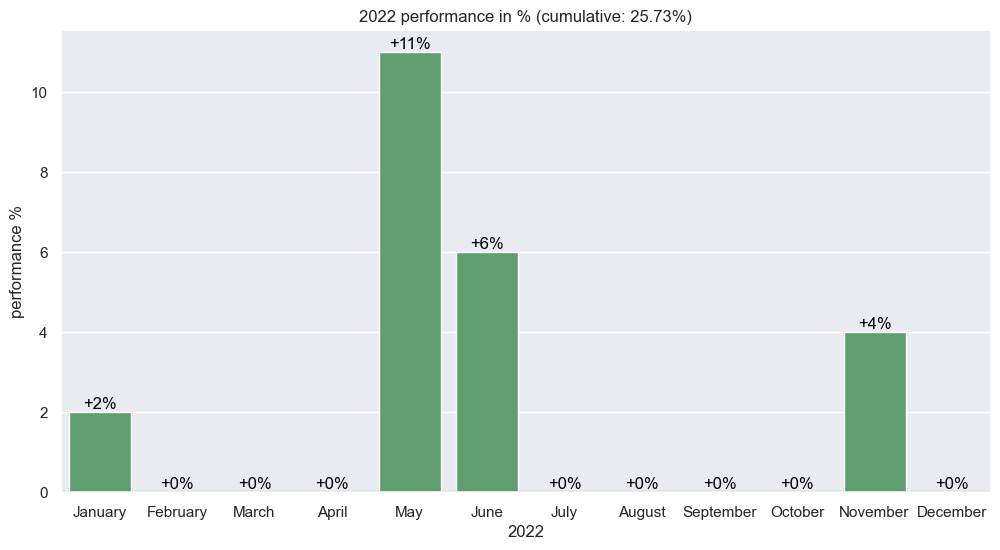

----- 2023 Cumulative Performances: 0.87% -----


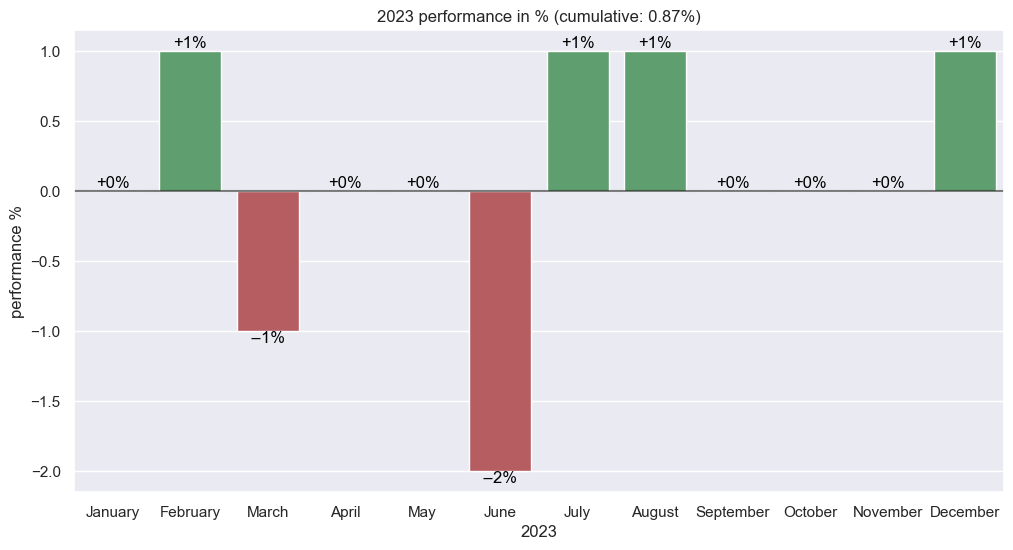

----- 2024 Cumulative Performances: 0.0% -----


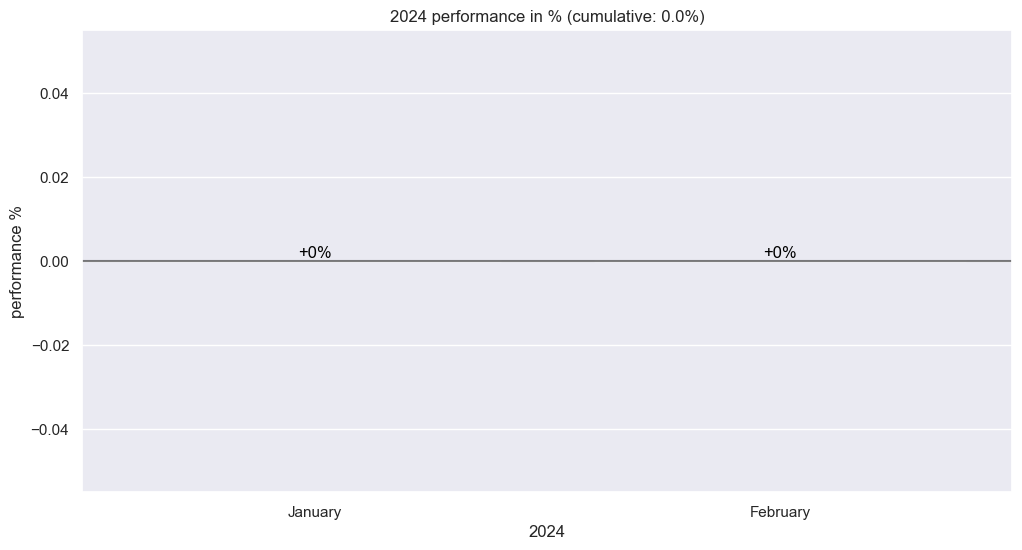

In [44]:
plot_bar_by_month(df_days)

<H2>Courbe de surapprentissage</H2>

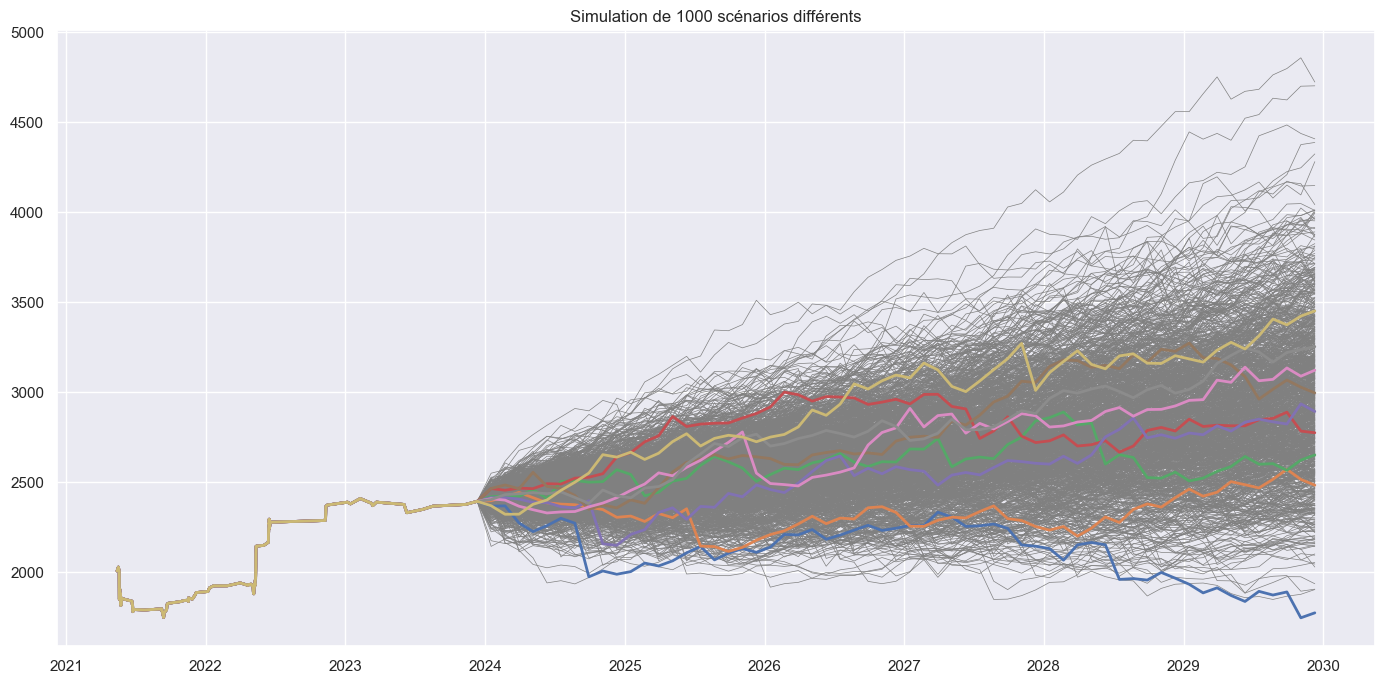

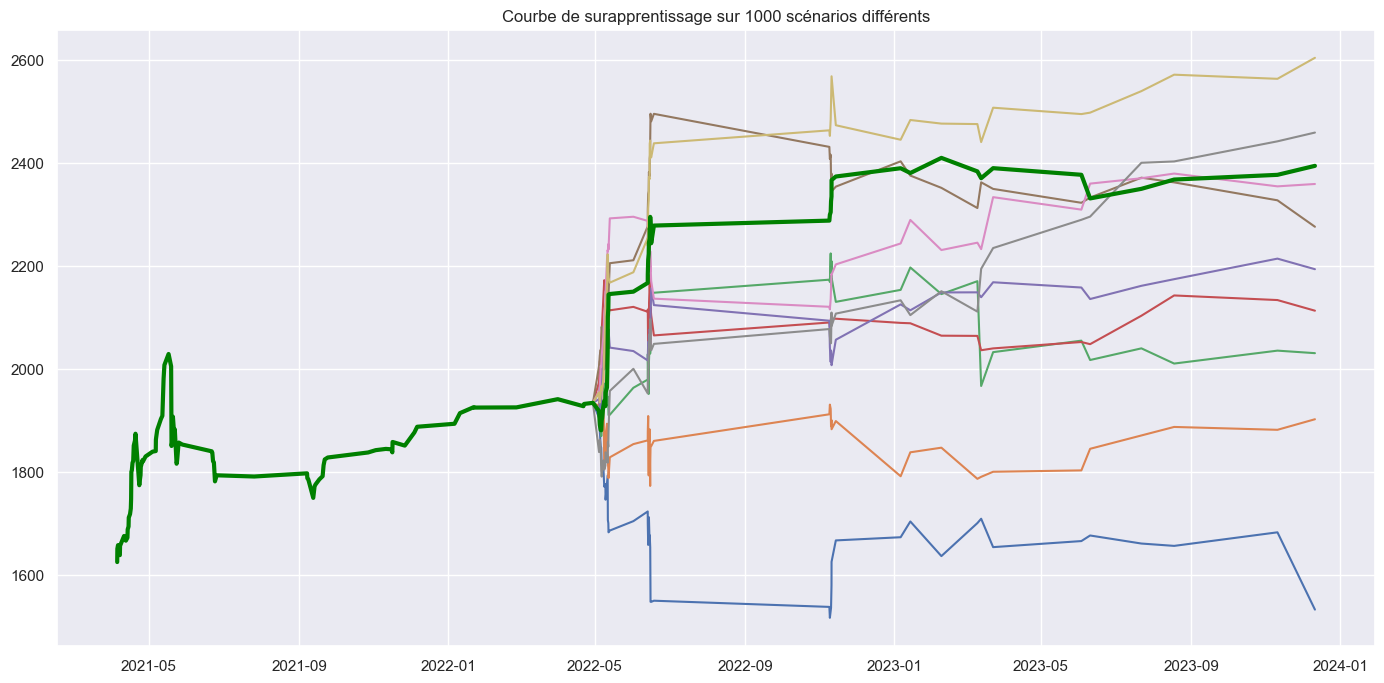

In [45]:
from utilities.plot_analysis import plot_futur_simulations, plot_train_test_simulation

# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-05-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

<H2>Optimisation des paramètres</H2>

<h3>Optuna</h3>

In [55]:
import optuna
from functools import partial

def create_default_params():
    default_params = {}
    for pair in pairs:
        default_params[pair] = {
            "src": "close",
            "ma_base_window": 5,
            "envelopes": [],
            "size": 0.01
        }
    return default_params

# Fonction d'optimisation pour study.optimize()
def optimize(trial):
    ma_base_window = trial.suggest_int("ma_base_window", 2, 11)     # entier entre 2 et 11
    envelopes = [
        trial.suggest_float(f"e{i+1}", low, high, step=0.01)        # [0.02..0.1], [0.05..0.13], ...
        for i, (low, high) in enumerate([(0.02, 0.1), (0.05, 0.13), (0.07, 0.15), (0.08, 0.2)])
    ]
    
    strat = Envelope(
        df=df.loc["2018":],
        type=["long", "short"],
        ma_base_window=ma_base_window,
        envelopes=envelopes,
        src='close'
    )
    
    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
    
    # Combinaison pondérée du Sharpe ratio et du portefeuille (40%-60%)
    objective_value = 0.4 * bt_result["sharpe_ratio"] + 0.6 * bt_result["wallet"]
    
    return objective_value

study = optuna.create_study(direction="maximize", 
                            storage="sqlite:///envelope.db", 
                            study_name=pair, 
                            load_if_exists=True,
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(partial(optimize), n_trials=500, n_jobs=8)       # A modifier selon les besoin et le hardware

# Test final avec les meilleurs paramètres
best_params = study.best_params

new_strat = Envelope(
    df=df,
    type=["long", "short"],
    ma_base_window=best_params['ma_base_window'],
    envelopes=[best_params[f'e{i}'] for i in range(1, len(best_params))],
    src='close'
)

new_strat.populate_indicators()
new_strat.populate_buy_sell()

bt_result = new_strat.run_backtest(initial_wallet=1000, leverage=1)

print(pair)
print("Valeur finale du portefeuille:   ", round(bt_result["wallet"],2), '$')
print("Ratio de Sharpe final:           ", round(bt_result["sharpe_ratio"],2))
print("Meilleur Score:                  ", round(study.best_value,2))
print("Paramètres optimaux: ", study.best_params)

[I 2024-02-02 12:53:27,148] Using an existing study with name 'TRX/USDT:USDT' instead of creating a new one.
[I 2024-02-02 12:53:31,964] Trial 500 finished with value: 3937.7075239435976 and parameters: {'ma_base_window': 9, 'e1': 0.1, 'e2': 0.12000000000000001, 'e3': 0.12000000000000001, 'e4': 0.14}. Best is trial 461 with value: 4336.517238613192.
[I 2024-02-02 12:53:31,982] Trial 507 finished with value: 3937.7075239435976 and parameters: {'ma_base_window': 9, 'e1': 0.1, 'e2': 0.12000000000000001, 'e3': 0.12000000000000001, 'e4': 0.14}. Best is trial 461 with value: 4336.517238613192.
[I 2024-02-02 12:53:32,041] Trial 503 finished with value: 3937.7075239435976 and parameters: {'ma_base_window': 9, 'e1': 0.1, 'e2': 0.12000000000000001, 'e3': 0.12000000000000001, 'e4': 0.14}. Best is trial 461 with value: 4336.517238613192.
[I 2024-02-02 12:53:32,045] Trial 505 finished with value: 3937.7075239435976 and parameters: {'ma_base_window': 9, 'e1': 0.1, 'e2': 0.12000000000000001, 'e3': 0.

TRX/USDT:USDT
Valeur finale du portefeuille:    7226.17 $
Ratio de Sharpe final:            2.03
Meilleur Score:                   4336.52
Paramètres optimaux:  {'ma_base_window': 9, 'e1': 0.1, 'e2': 0.12000000000000001, 'e3': 0.12000000000000001, 'e4': 0.12}


<H4>Graphiques<H4>

In [56]:
from optuna_dashboard import save_plotly_graph_object
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

plot_optimization_history(study)

In [57]:
# save_plotly_graph_object(study, plot_contour(study))
plot_contour(study)

In [49]:
# save_plotly_graph_object(study, plot_slice(study))
plot_slice(study)

In [58]:
# save_plotly_graph_object(study, plot_rank(study))
plot_rank(study)

C:\Users\jacks\AppData\Local\Temp\ipykernel_51936\2036422948.py:2: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [59]:
plot_param_importances(study)

In [ ]:
plot_edf(study)

<h3>Méthode classique par boucle</h3>

In [ ]:
# Méthode classique par boucle
import itertools
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

start_time = time.time()

ma_base_window_values = list(range(3, 7))
envelopes_values = [
    [round(val1, 3), round(val2, 3), round(val3, 3)] 
    for val1, val2, val3 in itertools.product(
        [i * 0.02 for i in range(2, 8)], 
        [i * 0.02 for i in range(8, 14)], 
        [i * 0.02 for i in range(14, 20)]
    )
]

# Use ThreadPoolExecutor for parallel execution
with ThreadPoolExecutor() as executor:
    def run_backtest(params):
        ma_base_window, envelopes = params
        current_strat = Envelope(
            df=df.loc["2019-01-02":],
            type=["long", "short"],
            ma_base_window=ma_base_window,
            envelopes=envelopes,
            src="close",
        )

        current_strat.populate_indicators()
        current_strat.populate_buy_sell()
        current_result = current_strat.run_backtest(initial_wallet=1000, leverage=1)
        return {'params': {'ma_base_window': ma_base_window, 'envelopes': envelopes}, 'result': current_result}

    results = list(tqdm(executor.map(run_backtest, itertools.product(ma_base_window_values, envelopes_values)), total=len(ma_base_window_values)*len(envelopes_values)))

best_result = max(results, key=lambda x: x['result']['wallet'])

print("Best Parameters:", best_result['params'])
print("Best Performance (Final Wallet Value):", best_result['result']['wallet'])
print("Sharpe Ratio: ", best_result['result']['sharpe_ratio'])
end_time = time.time()
elapsed_time = end_time - start_time
print("Temps de calcul total:", elapsed_time, "secondes")

